In [25]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

In [26]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/retinanet/retinanet_r50_fpn_1x_coco.py')

root='/opt/ml/detection/dataset/'

epoch = 'latest'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

cfg.seed=2021
cfg.gpu_ids = [1]
cfg.work_dir = './work_dirs/retinanet_r50_fpn_1x_trash'

# cfg.model.roi_head.bbox_head.num_classes = 10
cfg.model.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [27]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [28]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

/opt/ml/CV_18/level2-object-detection-level2-cv-18/Mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


load checkpoint from local path: ./work_dirs/retinanet_r50_fpn_1x_trash/latest.pth


In [29]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[                                ] 3/4871, 6.5 task/s, elapsed: 0s, ETA:   745s

/opt/ml/CV_18/level2-object-detection-level2-cv-18/Mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/opt/ml/CV_18/level2-object-detection-level2-cv-18/Mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 13.9 task/s, elapsed: 350s, ETA:     0s

In [30]:
# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,0 0.29652706 484.92004 594.1352 557.2854 661.6...,test/0000.jpg
1,0 0.30422977 756.80396 649.49286 898.25073 100...,test/0001.jpg
2,0 0.37328944 782.08057 404.4613 1023.51135 102...,test/0002.jpg
3,0 0.3800603 61.98117 144.56161 1005.1234 932.4...,test/0003.jpg
4,0 0.4115626 197.66272 264.93842 872.787 773.16...,test/0004.jpg


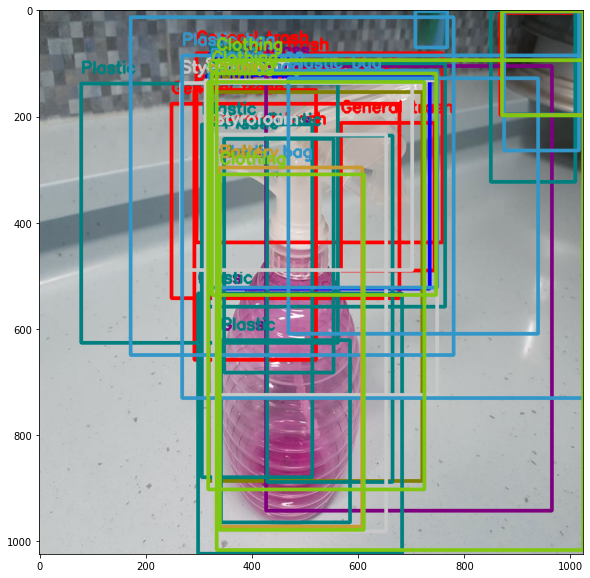

In [38]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt

# class 별 bbox 색
colors = [
    (255, 0, 0), 
    (0, 255, 0),
    (0, 0, 255),
    (127, 127, 0),
    (127, 0, 127),
    (0, 127, 127),
    (200, 200, 200),
    (50, 150, 200),
    (200, 155, 50),
    (130, 198, 20),
]
labels = {0: 'General trash', 1: 'Paper', 2: 'Paper pack', 3: 'Metal', 4: 'Glass', 5: 'Plastic', 6: 'Styrofoam', 7: 'Plastic bag', 8: 'Battery', 9: 'Clothing'}

# 이미지 경로
img_dir = '/opt/ml/detection/dataset/'
# output 파일 경로
output_dir = './work_dirs/retinanet_r50_fpn_1x_trash/submission_latest.csv'

test_result = pd.read_csv(output_dir)

file_names = test_result['image_id'].values.tolist()
bboxes = test_result['PredictionString'].values.tolist()

idx = random.choice(range(len(file_names)))
file_name = file_names[idx]
bbox = bboxes[idx].split()

image = cv2.imread(os.path.join(img_dir, file_name)).astype(np.uint8)
for i in range(0, len(bbox), 6):
    label = int(bbox[i])
    x_min = int(bbox[i + 2].split('.')[0])
    y_min = int(bbox[i + 3].split('.')[0])
    x_max = int(bbox[i + 4].split('.')[0])
    y_max = int(bbox[i + 5].split('.')[0])
    
    # bounding box 그리기
    image = cv2.rectangle(image, pt1=(x_min, y_min), pt2=(x_max, y_max), color=colors[label], thickness=5)
    # label text 넣기
    cv2.putText(image, labels[label], (x_min, y_min - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[label], 3)

plt.figure(figsize=(10,10))
plt.imshow(image)